In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cleaned-snappfood-persian-sentiment-analysis/cleaned_snappfood.csv


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [16]:
!pip install hazm

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.6/892.6 kB 15.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 62.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 72.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 41.7 MB/s eta 0:00:00
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9298 sha256=406e3b7777576b55c340cedd6991c5fd8f1f5aecdd0863e0c0c17814e2c19096
  Stored in directory: /root/.cache/pip/wheels/bc/be/39/c37ad168eb2ff644c9685f52554440372129450f0b8ed203dd
Successfully built flashtext
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2

In [6]:
df= pd.read_csv('/kaggle/input/cleaned-snappfood-persian-sentiment-analysis/cleaned_snappfood.csv'
                ,encoding='utf-8', sep='\t+', on_bad_lines='skip', engine='python')

In [10]:
# Load dataset
df = pd.read_csv("/kaggle/input/cleaned-snappfood-persian-sentiment-analysis/cleaned_snappfood.csv")

# Check dataset info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65973 entries, 0 to 65972
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   comment          65973 non-null  object
 1   label            65973 non-null  int64 
 2   comment_length   65973 non-null  int64 
 3   comment_cleaned  65973 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.0+ MB
None


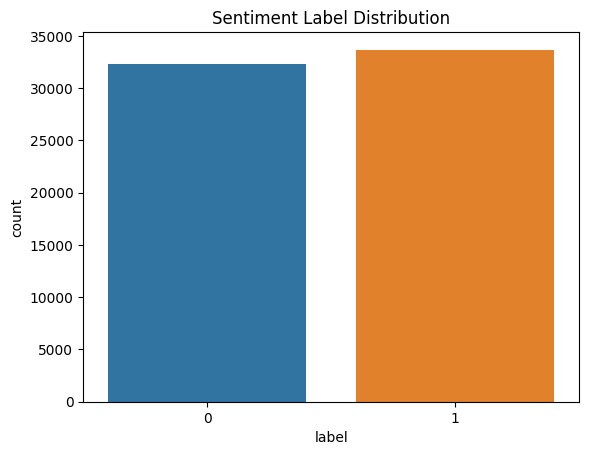

In [11]:
# Label distribution
sns.countplot(x=df["label"])
plt.title("Sentiment Label Distribution")
plt.show()

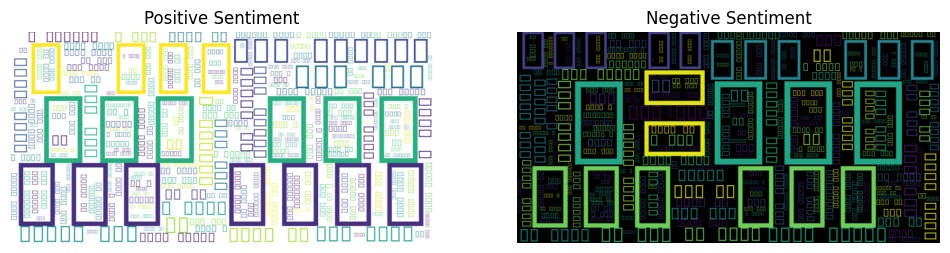

In [14]:
# Word Cloud for Positive & Negative comments
positive_text = " ".join(df[df['label'] == 1]['comment_cleaned'])
negative_text = " ".join(df[df['label'] == 0]['comment_cleaned'])

wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_neg = WordCloud(width=800, height=400, background_color='black').generate(negative_text)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Sentiment")

plt.subplot(1,2,2)
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Sentiment")

plt.show()

In [17]:
# Text Preprocessing

from hazm import Normalizer, word_tokenize, stopwords_list
from sklearn.feature_extraction.text import TfidfVectorizer

# Persian Text Normalization
normalizer = Normalizer()
df["comment_cleaned"] = df["comment_cleaned"].apply(lambda x: normalizer.normalize(x))

# Remove Stopwords
stopwords = set(stopwords_list())
df["comment_cleaned"] = df["comment_cleaned"].apply(lambda x: " ".join([word for word in word_tokenize(x) if word not in stopwords]))

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = vectorizer.fit_transform(df["comment_cleaned"])
y = df["label"]


In [18]:
# Train-Test Split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [19]:
# Model Selection & Training

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Model Training
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(kernel='linear')
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")


Naive Bayes Accuracy: 0.8127
Logistic Regression Accuracy: 0.8252
Random Forest Accuracy: 0.8154
SVM Accuracy: 0.8225


In [20]:
# Hyperparameter Tuning

from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],
    'max_iter': [200, 500, 1000]
}

grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
best_model = grid.best_estimator_


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best Parameters: {'C': 1, 'max_iter': 200}


In [21]:
# Deep Learning Approach (BERT)

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch

tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("HooshvareLab/bert-fa-base-uncased", num_labels=2)

# Tokenize dataset
def tokenize_function(examples):
    return tokenizer(examples["comment_cleaned"], padding="max_length", truncation=True)

# Convert to Torch Dataset
train_encodings = tokenizer(list(df["comment_cleaned"]), truncation=True, padding=True, max_length=128)
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_encodings['input_ids']), torch.tensor(y.values))

# Training
training_args = TrainingArguments(output_dir="./results", num_train_epochs=3, per_device_train_batch_size=8, per_device_eval_batch_size=8)
trainer = Trainer(model=model, args=training_args, train_dataset=train_dataset)

trainer.train()


config.json:   0%|          | 0.00/440 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [22]:
# Model Evaluation

from sklearn.metrics import classification_report

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.81      0.85      0.83      6460
           1       0.85      0.80      0.82      6735

    accuracy                           0.83     13195
   macro avg       0.83      0.83      0.83     13195
weighted avg       0.83      0.83      0.83     13195



In [23]:
# Deploying the Model

import joblib

# Save Model
joblib.dump(best_model, "sentiment_model.pkl")

# Load and Predict
model = joblib.load("sentiment_model.pkl")
sample_comment = ["این غذا خیلی بد بود"]
sample_vector = vectorizer.transform(sample_comment)
prediction = model.predict(sample_vector)
print("Prediction:", "Positive" if prediction[0] == 1 else "Negative")


Prediction: Negative


In [25]:
import joblib

# Save trained model
joblib.dump(best_model, "sentiment_model.pkl")

# Save the trained TF-IDF Vectorizer
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")


['tfidf_vectorizer.pkl']

In [26]:
import joblib

# Load the trained model and vectorizer
model = joblib.load("sentiment_model.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")  # Ensure you save and load the vectorizer

# Sample comment
sample_comment = ["این غذا خیلی بد بود"]

# Transform the comment
sample_vector = vectorizer.transform(sample_comment)

# Predict
prediction = model.predict(sample_vector)[0]

# Print Prediction with Actual Value
print(f"Prediction Value: {prediction}")  
print(f"Sentiment: {'Positive' if prediction == 1 else 'Negative'}")


Prediction Value: 0
Sentiment: Negative
